# Influence function estimation at Univerity of Iowa
xchong@lbl.gov, 16th July 2024
awojdyla@lbl.gov

First, we load the influence function collected by applying 10 V to each cell. Then we generate ramdom voltages and use the influence function to get the results. In this case, we have multiple pairs of (input voltages, resutls). After that, we train a neural network to learn the mapping between random voltages and resulted wavefront. Finally, we reconstruct the influence function. We get good results in this task (with simulated data), which proves that DL model can reconstruct the influence function from random data.

In [1]:
# load the influence funtion from file
import numpy as np
import scipy.io as sc
import matplotlib.pyplot as plt  
import math


# 1 extract the influence function from the npy files

In [2]:
# load the data from txt files
ifs = np.load("./seg3A_cells_1-18_ifs.npy")
ifs= ifs[:,:16]
print(ifs.shape)

(1440, 16)


In [3]:
# remove the bad cells: 0,1,3
ifs_cleaned=[]
for i in range(ifs.shape[0]):
    ifs_each=ifs[i]
    ifs_each_cleaned= np.delete(ifs_each, [0,1,3])
    ifs_cleaned.append(ifs_each_cleaned)
ifs_cleaned= np.array(ifs_cleaned)
print(ifs_cleaned.shape)


(1440, 13)


In [4]:
# generate num random float number in range of [l,h]
def randfloat(num,l,h):
    a = h-l
    b = h-a
    out = (np.random.rand(num)*a+b).tolist()
    out = np.array(out)
    return out

In [5]:
# generate 5000 input and output data
input_list=[]
result_list=[]
for i in range(5000):
    input = randfloat(13,0,10)
    result = np.dot(ifs_cleaned,input)

    input_list.append(input)
    result_list.append(result)

input_np = np.array(input_list)
result_np = np.array(result_list)

np.savetxt("input5000_13.txt",input_np) 
np.savetxt("result5000_13.txt",result_np) 

In [6]:
# load the data from txt files
input = np.loadtxt("input5000_13.txt", delimiter=' ')
result = np.loadtxt("result5000_13.txt",delimiter=' ')

# 2 define a neural network to learn the mappling between random voltages and resulted wavefront

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader



device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
# random seed
torch.manual_seed(0)


class Discriminator(nn.Module):
    def __init__(self, input_dim,output_dim):
        super(Discriminator, self).__init__()
        self.layer1 = nn.Linear(input_dim, 128)
        self.layer2 = nn.Linear(128, 256)
        self.layer3 = nn.Linear(256, output_dim)
    
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        return x
# from arch_unet import UNet
# from torch.nn import functional as F
# class Discriminator(nn.Module):
#     def __init__(self, input_dim,output_dim):
#         super(Discriminator, self).__init__()
#         self.layer1 = nn.Linear(input_dim, 1024)
#         self.UNet = UNet()
#         #self.layer11 = nn.Linear(512, 1024)
#         self.layer2 = nn.Linear(1024, 2048)
#         self.layer3 = nn.Linear(2048, output_dim)
#         self.tanh = nn.Tanh()
#         self.drop1 = nn.Dropout(0.1)
#         self.drop2 = nn.Dropout(0.1)
#         self.drop3 = nn.Dropout(0.1)
#         # self.layer1 = nn.Linear(20, 128)
#         # self.layer2 = nn.Linear(128, 256)
#         # self.layer3 = nn.Linear(256, 41)


#     def forward(self, x):
#         x = self.layer1(x)
#         x = F.relu(x)
#         x = self.drop1(x)

#         b,_= x.shape
#         x = x.reshape(b,1,32,32)
#         x = self.UNet(x)
#         x = x.reshape(b,-1)


#         x = self.layer2(x)
#         x = F.relu(x)
#         x = self.drop2(x)

#         x = self.layer3(x)

#         return x
    
class DataLoader_train(Dataset):
    def __init__(self,input_list,result_list):
        super(DataLoader_train, self).__init__()
  
        
        self.train_x = input_list
        self.train_result = result_list

        print('fetch {} samples for training'.format(len(self.train_x)))

    def __getitem__(self, index):

        x = self.train_x[index]
        result = self.train_result[index]

        x = np.array(x, dtype=np.float32)
        result = np.array(result, dtype=np.float32)


        x = torch.from_numpy(x)
        result = torch.from_numpy(result)

        return x,result

    def __len__(self):
        return len(self.train_x)
    
TrainingDataset = DataLoader_train(input,result)
TrainingLoader = DataLoader(dataset=TrainingDataset,
                            num_workers=0,
                            batch_size=256,
                            shuffle=False,
                            pin_memory=False,
                            drop_last=True)


input_dim = 13
output_dim = 1440

cuda
fetch 5000 samples for training


In [8]:
#train the model D and save it to D.ckpt (if already trained, skip this step)
D = Discriminator(input_dim,output_dim).to(device)
optimizer_D = optim.Adam(D.parameters(), lr=0.0001,weight_decay=1e-8)


D = D.to(device)

num_epochs = 1000
batch_size = 256

for epoch in range(num_epochs):

    D.train()
    for iteration, data in enumerate(TrainingLoader):
        x, result = data
        x = x.to(device)
        result = result.to(device)
        optimizer_D.zero_grad()
        predict = D(x)
        diff = result*1e3 - predict
        loss = torch.mean(diff**2)
  
        loss.backward()
        optimizer_D.step()
        if (epoch + 1) % 100 == 0:
            print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}")


torch.save(D.state_dict(), "./D_13.ckpt")

/global/homes/x/xchong/.local/perlmutter/python-3.11/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


Epoch [100/1000], Loss: 25.2597
Epoch [100/1000], Loss: 30.0858
Epoch [100/1000], Loss: 26.9520
Epoch [100/1000], Loss: 25.2748
Epoch [100/1000], Loss: 25.5642
Epoch [100/1000], Loss: 26.2015
Epoch [100/1000], Loss: 25.6084
Epoch [100/1000], Loss: 26.8506
Epoch [100/1000], Loss: 27.2978
Epoch [100/1000], Loss: 27.2699
Epoch [100/1000], Loss: 25.6394
Epoch [100/1000], Loss: 23.9721
Epoch [100/1000], Loss: 24.1835
Epoch [100/1000], Loss: 24.0740
Epoch [100/1000], Loss: 27.0162
Epoch [100/1000], Loss: 26.6803
Epoch [100/1000], Loss: 27.9113
Epoch [100/1000], Loss: 24.5210
Epoch [100/1000], Loss: 26.5351
Epoch [200/1000], Loss: 4.6413
Epoch [200/1000], Loss: 4.7028
Epoch [200/1000], Loss: 4.6263
Epoch [200/1000], Loss: 4.4290
Epoch [200/1000], Loss: 4.2784
Epoch [200/1000], Loss: 4.3219
Epoch [200/1000], Loss: 4.9899
Epoch [200/1000], Loss: 4.8264
Epoch [200/1000], Loss: 4.6809
Epoch [200/1000], Loss: 4.4712
Epoch [200/1000], Loss: 4.3774
Epoch [200/1000], Loss: 4.6716
Epoch [200/1000], Lo

In [9]:
# load the trained model 
D = Discriminator(input_dim,output_dim).to(device)
D.load_state_dict(torch.load("./D_13.ckpt"))
D.eval()

Discriminator(
  (layer1): Linear(in_features=13, out_features=128, bias=True)
  (layer2): Linear(in_features=128, out_features=256, bias=True)
  (layer3): Linear(in_features=256, out_features=1440, bias=True)
)

In [10]:
# get the test sample (x= solution_V, y = wavefront_w)

y_mm = np.linspace(-40,40,1664)
crop_start = 150
crop_end = 1590
y_mm = y_mm[crop_start:crop_end]
y_mm = np.expand_dims(y_mm, axis=1)

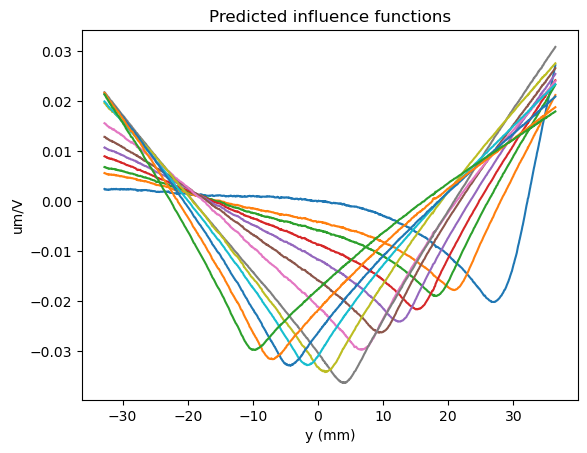

In [11]:
# plot the predicted influence functions
for param in D.parameters():
    param.requires_grad = False



ifs=[]
for i in range(13):
    test_input = np.zeros(13, dtype=np.float32)
    test_input[i] = 10
    test_input = np.expand_dims(test_input, axis=0)

    D_w = D(torch.from_numpy(test_input).cuda()).squeeze()
    D_w = D_w.cpu()*1e-3

    ifs.append(D_w)
    
ifs=np.array(ifs).transpose((1,0))
plt.plot(y_mm, ifs)

plt.title("Predicted influence functions")
plt.xlabel("y (mm)")
plt.ylabel("um/V")
plt.show()

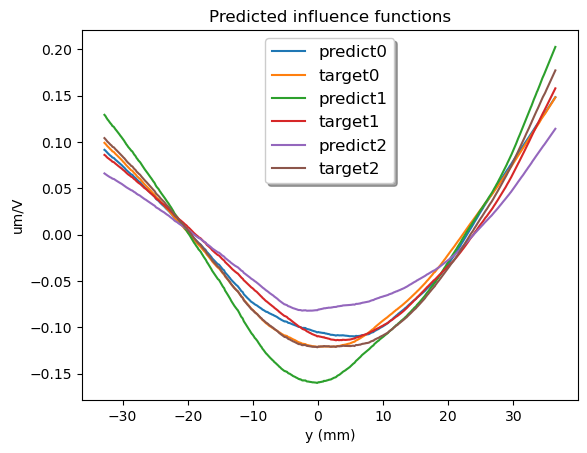

In [12]:
for param in D.parameters():
    param.requires_grad = False



test_index=100
for test_index in range(3):
    test_input = input[test_index].astype(np.float32)
    test_input = np.expand_dims(test_input, axis=0)
    D_w = D(torch.from_numpy(test_input).cuda()).squeeze()
    D_w = D_w.cpu()*1e-3



    plt.plot(y_mm, D_w,label="predict"+str(test_index))
    plt.plot(y_mm, result[test_index].cpu(),label="target"+str(test_index))

plt.legend(loc='upper center', shadow=True, fontsize='large')
plt.title("Predicted influence functions")
plt.xlabel("y (mm)")
plt.ylabel("um/V")
plt.show()

Text(0, 0.5, 'Wavefront (nm)')

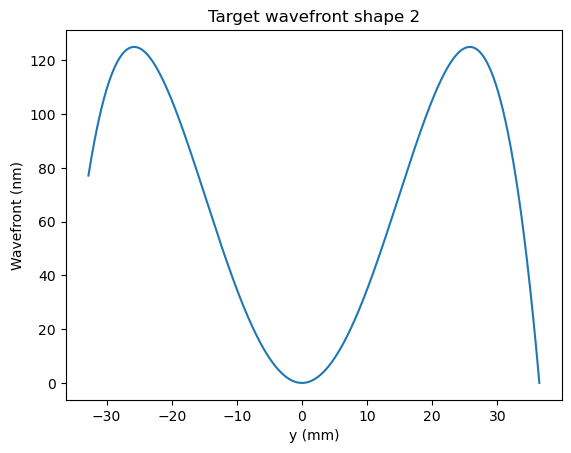

In [13]:
# define a random wavefront shape

yc_mm = 0
target_shape_m = (((y_mm-yc_mm)/np.max(y_mm))**2-((y_mm-yc_mm)/np.max(y_mm))**4)*100e-9*5
wavefront_w = target_shape_m


plt.plot(y_mm,wavefront_w*1e9)
plt.title("Target wavefront shape 2")
plt.xlabel("y (mm)")
plt.ylabel("Wavefront (nm)")

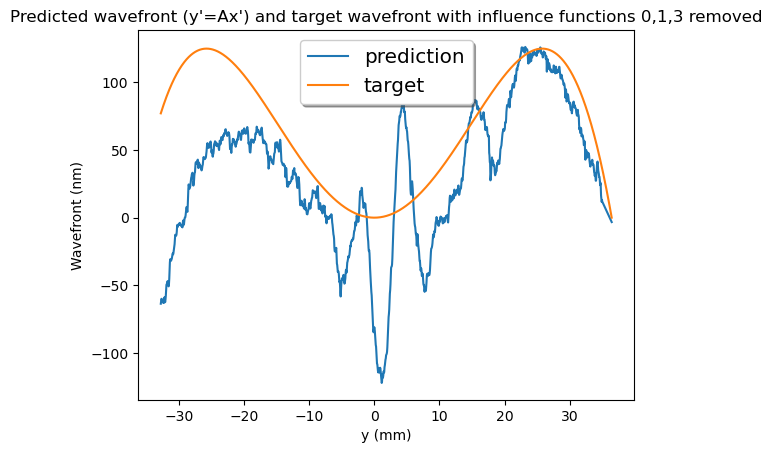

In [14]:
# get the solution voltage by matrix inversion
solution_V = np.dot(np.linalg.pinv(ifs_cleaned),wavefront_w)
solution_w = np.dot(ifs_cleaned,solution_V)

plt.plot(y_mm, solution_w*1e9, label ="prediction")
plt.plot(y_mm, wavefront_w*1e9, label="target")
legend = plt.legend(loc='upper center', shadow=True, fontsize='x-large')
plt.title("Predicted wavefront (y'=Ax') and target wavefront with influence functions 0,1,3 removed")
plt.xlabel("y (mm)")
plt.ylabel("Wavefront (nm)")
plt.show()

np.save("seg3A_cells_1-18_targetwave2_m.npy",wavefront_w)
np.save("seg3A_cells_1-18_predictwave2_m.npy",solution_w)

tensor([-63.6345, -62.0905, -60.0040,  ...,  -2.2396,  -2.7058,  -3.2162])
[[7.71339483e-08]
 [7.78655447e-08]
 [7.85904451e-08]
 ...
 [2.62287333e-09]
 [1.31577974e-09]
 [0.00000000e+00]]


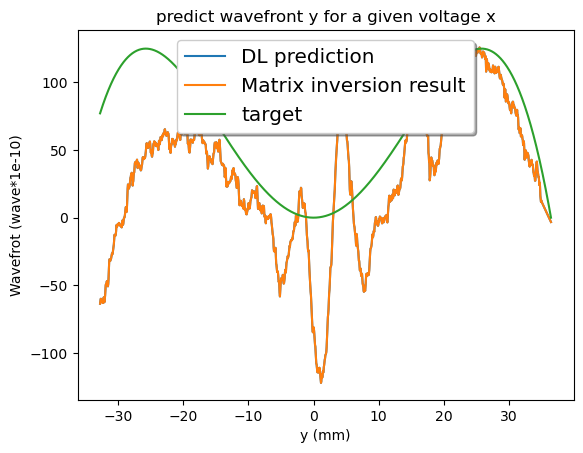

In [15]:
# get the wavefront by neural networl using the voltage
for param in D.parameters():
    param.requires_grad = False


# use solution_V as the input of D(), the output should be same as wavefront_w
test_input = np.array(solution_V, dtype=np.float32).squeeze()*1e6
D_w = D(torch.from_numpy(test_input).cuda()).cpu()

print(D_w)
print(wavefront_w)

plt.plot(y_mm, D_w, label ="DL prediction")
plt.plot(y_mm, solution_w*1e9, label ="Matrix inversion result")
plt.plot(y_mm, wavefront_w*1e9, label="target")
legend = plt.legend(loc='upper center', shadow=True, fontsize='x-large')
plt.title("predict wavefront y for a given voltage x")
plt.xlabel("y (mm)")
plt.ylabel("Wavefrot (wave*1e-10)")
plt.show()

In [16]:
#define generate, which is to find x for a given y
from torch.nn import functional as F
class Generator(nn.Module):
    def __init__(self, noise_dim, output_dim):
        super(Generator, self).__init__()
        self.layer1 = nn.Linear(noise_dim, 64)
        self.layer2 = nn.Linear(64, 128)
        self.layer3 = nn.Linear(128, output_dim)
        self.sigmoid = nn.Sigmoid()
        self.tanh = nn.Tanh()
        self.drop1 = nn.Dropout(0.1)
        self.drop2 = nn.Dropout(0.1)
        self.drop3 = nn.Dropout(0.1)

    def forward(self, x):
        x = self.layer1(x)
        # x = F.relu(x)
        # x = self.drop1(x)
        
        x = self.layer2(x)
        # x = F.relu(x)
        # x = self.drop2(x)
        
        x = self.layer3(x)
        # x = F.relu(x)
        # x = self.drop3(x)
        #x = self.tanh(x)
        #x = self.sigmoid(x)*100
        return x

noise_dim = 2
G = Generator(noise_dim, input_dim).to(device)

for param in D.parameters():
    param.requires_grad = False


optimizer_G = optim.Adam(G.parameters(), lr=0.0001)

num_epochs = 50000
batch_size = 256

# the desired output
best_input = None
best_output = wavefront_w*1e9
best_loss = float('inf')

best_output = np.array(best_output, dtype=np.float32)
best_output = torch.from_numpy(best_output).squeeze().cuda()

for epoch in range(num_epochs):
    # create a noise
    noise = torch.randn(batch_size, noise_dim).to(device)

    # use G to predict input for a given y, we have x_hat = Gen (noise)
    gen_input = torch.mean(G(noise),dim=0)

    # minimize |D(x_hat)-y|
    D_output = D(gen_input)
    diff = D_output-best_output
    loss = torch.mean(diff**2)
    
    # optimize
    optimizer_G.zero_grad()
    loss.backward()
    optimizer_G.step()
    
    # update the best result
    if loss.item() < best_loss:
        best_loss = loss.item()
        best_input = gen_input
    
    # print the process
    if (epoch + 1) % 1000 == 0:
        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}")
torch.save(G.state_dict(), "./G.ckpt")

Epoch [1000/50000], Loss: 4243.6738
Epoch [2000/50000], Loss: 3627.9438
Epoch [3000/50000], Loss: 3176.3140
Epoch [4000/50000], Loss: 2962.8015
Epoch [5000/50000], Loss: 2851.9297
Epoch [6000/50000], Loss: 2819.0459
Epoch [7000/50000], Loss: 2814.0959
Epoch [8000/50000], Loss: 2813.6094
Epoch [9000/50000], Loss: 2813.5906
Epoch [10000/50000], Loss: 2813.5977
Epoch [11000/50000], Loss: 2813.5938
Epoch [12000/50000], Loss: 2813.5925
Epoch [13000/50000], Loss: 2813.6001
Epoch [14000/50000], Loss: 2813.5872
Epoch [15000/50000], Loss: 2813.5889
Epoch [16000/50000], Loss: 2813.5903
Epoch [17000/50000], Loss: 2813.5911
Epoch [18000/50000], Loss: 2813.5872
Epoch [19000/50000], Loss: 2813.5969
Epoch [20000/50000], Loss: 2813.6843
Epoch [21000/50000], Loss: 2813.5869
Epoch [22000/50000], Loss: 2813.5872
Epoch [23000/50000], Loss: 2813.5889
Epoch [24000/50000], Loss: 2813.5903
Epoch [25000/50000], Loss: 2813.5903
Epoch [26000/50000], Loss: 2813.5876
Epoch [27000/50000], Loss: 2813.5901
Epoch [280

In [17]:
# load the trained model 
G = G = Generator(noise_dim, input_dim).to(device)
G.load_state_dict(torch.load("./G.ckpt"))
G.eval()

Generator(
  (layer1): Linear(in_features=2, out_features=64, bias=True)
  (layer2): Linear(in_features=64, out_features=128, bias=True)
  (layer3): Linear(in_features=128, out_features=13, bias=True)
  (sigmoid): Sigmoid()
  (tanh): Tanh()
  (drop1): Dropout(p=0.1, inplace=False)
  (drop2): Dropout(p=0.1, inplace=False)
  (drop3): Dropout(p=0.1, inplace=False)
)

[ -12.671862  -68.89459   166.10245  -154.42804   102.74044   -71.03847
  264.90784  -449.91754   486.16803  -307.60162   178.97343  -107.899994
   28.650717]
[-63.619476  -62.075745  -59.989315  ...  -2.2611775  -2.7275188
  -3.2382479]
[[77.13394826]
 [77.86554469]
 [78.59044513]
 ...
 [ 2.62287333]
 [ 1.31577974]
 [ 0.        ]]


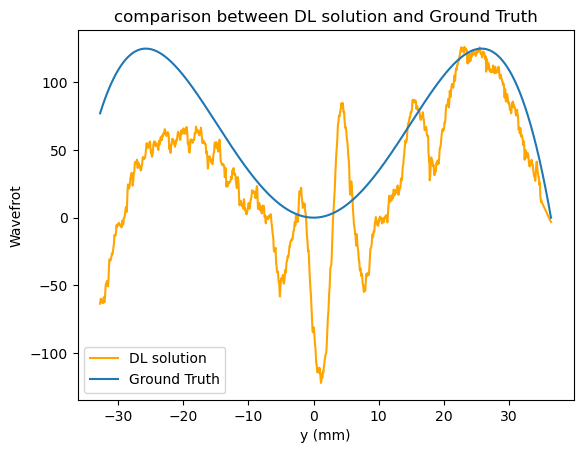

In [21]:
# the predicted x for a given y (Ax=y)
Gen_w_DL = D(best_input).cpu().detach().numpy()
best_input_np =best_input.cpu().detach().numpy()
Gen_w_dot = np.dot(ifs_cleaned,best_input_np)
print(best_input_np)
print(Gen_w_DL)
print(wavefront_w*1e9)
plt.plot(y_mm, Gen_w_DL,color='orange')
plt.plot(y_mm, wavefront_w*1e9)
plt.legend(['DL solution', 'Ground Truth'])
plt.title("comparison between DL solution and Ground Truth")
plt.xlabel("y (mm)")
plt.ylabel("Wavefrot")
plt.show()

DL prediction tensor([-1.2672e-05, -6.8895e-05,  1.6610e-04, -1.5443e-04,  1.0274e-04,
        -7.1038e-05,  2.6491e-04, -4.4992e-04,  4.8617e-04, -3.0760e-04,
         1.7897e-04, -1.0790e-04,  2.8651e-05], device='cuda:0',
       grad_fn=<MulBackward0>)
Matrix inversion prediction: [[-1.26588484e-05]
 [-6.89277550e-05]
 [ 1.66145642e-04]
 [-1.54479231e-04]
 [ 1.02803383e-04]
 [-7.10570324e-05]
 [ 2.64884195e-04]
 [-4.49922430e-04]
 [ 4.86151944e-04]
 [-3.07491165e-04]
 [ 1.78859950e-04]
 [-1.07876247e-04]
 [ 2.86618666e-05]]


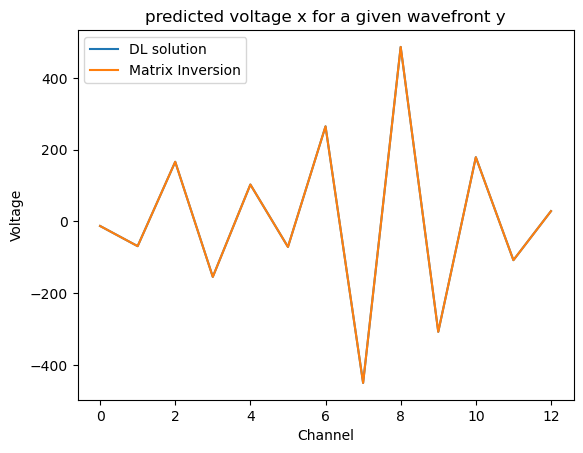

In [19]:
#plot the solution of DL method: best_input_np
solution_V2 = np.dot(np.linalg.pinv(ifs_cleaned),wavefront_w)
print("DL prediction",best_input*1e-6)
print("Matrix inversion prediction:",solution_V2)
plt.plot(best_input_np[:18])
plt.plot(solution_V2[:18]*1e6)
plt.legend(['DL solution', 'Matrix Inversion'])
plt.title("predicted voltage x for a given wavefront y")
plt.xlabel("Channel")
plt.ylabel("Voltage")
plt.show()